In [ ]:
%pip install qiskit qiskit-ibm-runtime qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 10.7 MB/s eta 0:00:00


In [1]:
# Import Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# Import Parameter class
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from copy import deepcopy
from math import pi
import numpy as np

In [2]:
def F_to_theta(F):
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        theta = np.arcsin(2*F - 1)
    return theta

def F_to_lambda(F):
    if F < 0 or F > 1:
        raise Exception('Fidelity must be between 0 and 1.')
    else:
        lambd = (4*F-1)/3
    return lambd

n = 2
qr = QuantumRegister(2+2)
cr = ClassicalRegister(2+2*(n-1))

theta = F_to_theta(0.75)
lambd = F_to_lambda(0.75)

control_qubits = [qr[0], qr[1]]
target_qubits = [qr[2], qr[3]]

In [3]:
def source_old_circ(flag):
    source_old_circ = QuantumCircuit(qr,cr)
    source_old_circ.h(control_qubits[0])
    if flag:
        source_old_circ.cx(control_qubits[0], control_qubits[1])
    else:
        source_old_circ.measure(control_qubits[0],cr[0])
        source_old_circ.h(control_qubits[1])
        source_old_circ.measure(control_qubits[1],cr[1])
    return source_old_circ

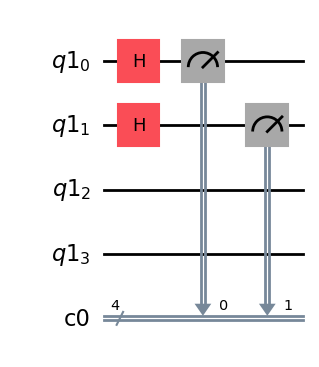

In [4]:
source_old_circ(True).draw(output='mpl')
source_old_circ(False).draw(output='mpl')

In [5]:
def source_new_circ(flag):
    source_new_circ = QuantumCircuit(qr,cr)
    source_new_circ.h(target_qubits[0])
    if flag:
        source_new_circ.cx(target_qubits[0], target_qubits[1])
    else:
        source_new_circ.measure(target_qubits[0],cr[0])
        source_new_circ.h(target_qubits[1])
        source_new_circ.measure(target_qubits[1],cr[1])
    return source_new_circ

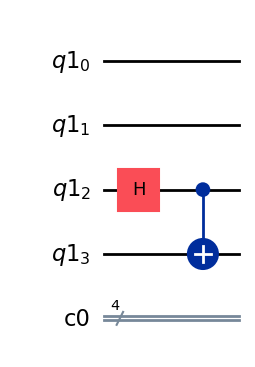

In [6]:
source_new_circ(True).draw(output='mpl')
#source_new_circ(False).draw()

In [7]:
def purification_circ(round):
    purification_circ = QuantumCircuit(qr,cr)
    # Implement a Pauli-Y gate on Alice's control qubit
    #purification_circ.y(control_qubits[0])
    # Implement a Pauli-Y gate on Alice's target qubit
    #purification_circ.y(target_qubits[0])
    purification_circ.cx(control_qubits[0], target_qubits[0])
    purification_circ.cx(control_qubits[1], target_qubits[1])
    #purification_circ.y(control_qubits[0])

    purification_circ.measure(target_qubits[0], cr[2*round])
    purification_circ.measure(target_qubits[1], cr[2*round+1])

    #purification_circ.x(target_qubits[0]).c_if(cr[2*round], 1)
    #purification_circ.x(target_qubits[1]).c_if(cr[2*round+1], 1)
    purification_circ.reset(target_qubits[0])
    purification_circ.reset(target_qubits[1])

    return purification_circ

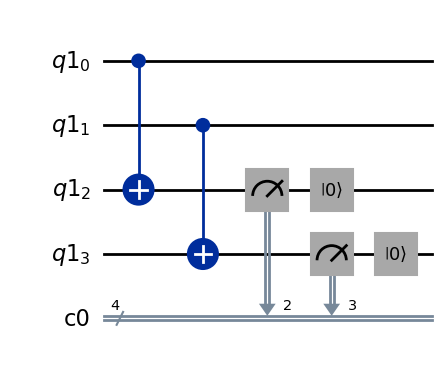

In [8]:
purification_circ(1).draw(output='mpl')

In [9]:
measurement_circ = QuantumCircuit(qr,cr)

measurement_circ.cx(control_qubits[0], control_qubits[1])
measurement_circ.h(control_qubits[0])

measurement_circ.measure(control_qubits[0], cr[0])
measurement_circ.measure(control_qubits[1], cr[1])

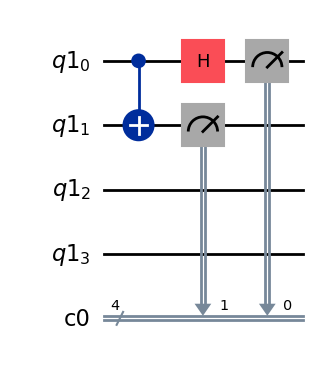

In [10]:
measurement_circ.draw(output='mpl')

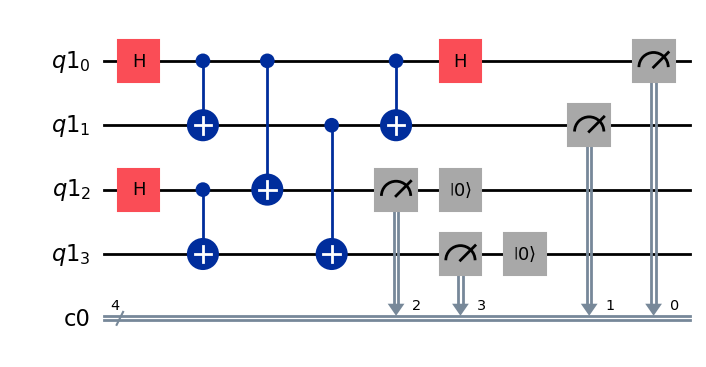

In [11]:
# Check.

experiment_circ = source_old_circ(True) & source_new_circ(True) & purification_circ(1) & measurement_circ

experiment_circ.draw(output='mpl')

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_rensselaer')

# generate a simulator that mimics the real quantum system with the latest calibration results
# backend = AerSimulator.from_backend(backend)

# You can use a fixed seed to get fixed results.
# options = {"simulator": {"seed_simulator": 42}}
# options = {}

# Define Sampler
sampler = Sampler(mode=backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

In [13]:
# Exact Sampler instead
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
# pm = generate_preset_pass_manager(optimization_level=1)

In [14]:
def build_isa_circuit(flag):
    experiment_circ = source_old_circ(np.random.rand()<lambd)
    if flag:
        for round in range(1,n):
            experiment_circ = experiment_circ & source_new_circ(np.random.rand()<lambd) & purification_circ(round)
    experiment_circ = experiment_circ & measurement_circ
    # Convert to an ISA circuit and layout-mapped observables.
    isa_circuit = pm.run(experiment_circ)
    #isa_circuit.draw()
    return isa_circuit

In [15]:
from collections import Counter

z=Counter({})

# Run calculation
job = sampler.run([build_isa_circuit(True)],shots=16384)
print(f"Job ID: {job.job_id()}")

Job ID: cx8w5bdztp30008fz9e0


In [16]:
finished = service.job(job_id="cx8w5bdztp30008fz9e0")
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
z += Counter(pub_result.data.c0.get_counts())

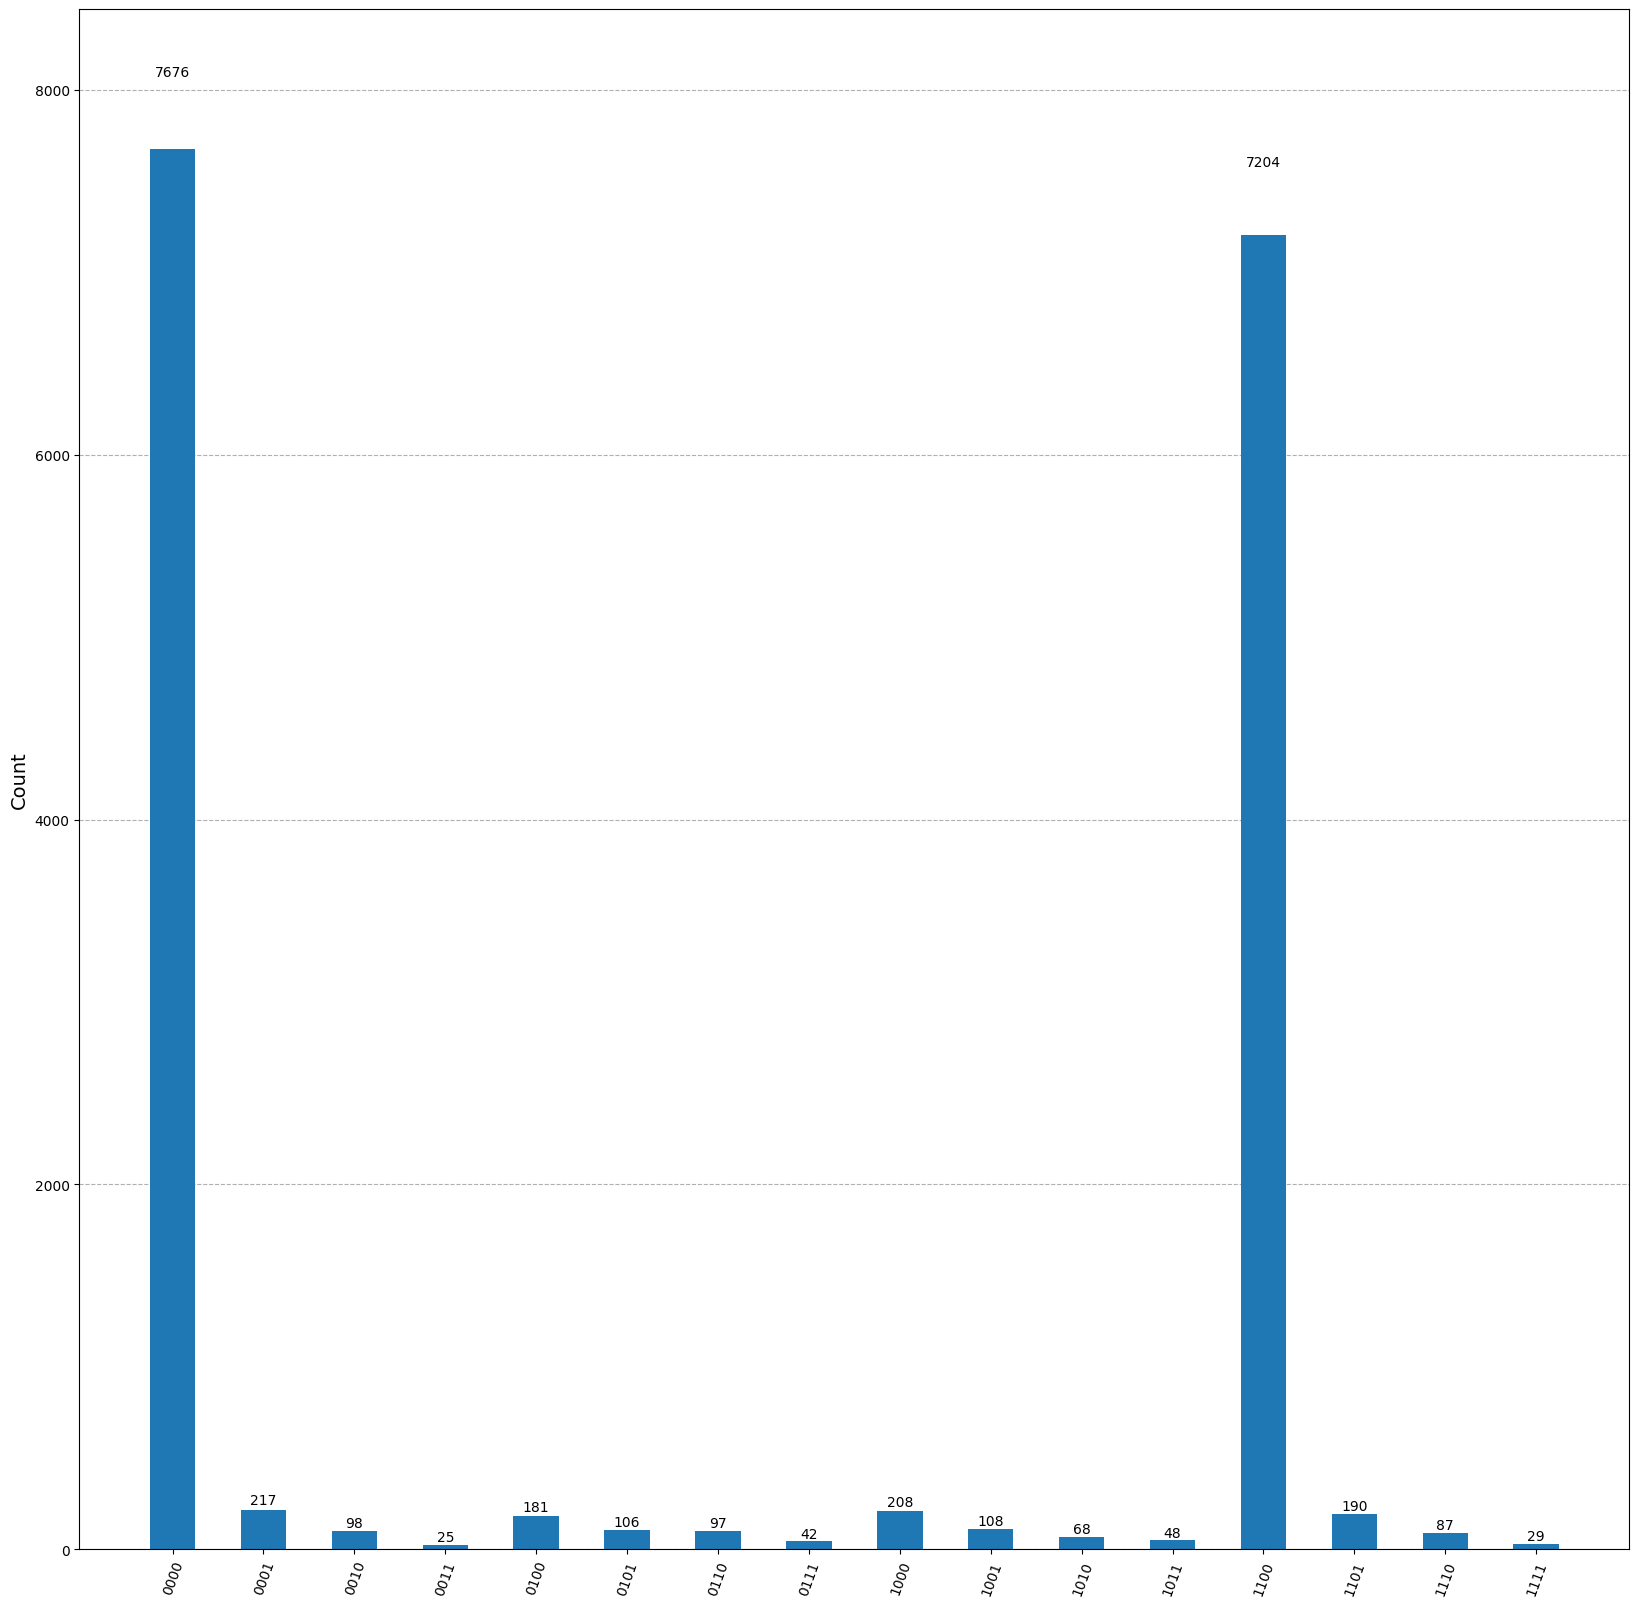

In [17]:
from qiskit.visualization import plot_histogram

plot_histogram(data=z, figsize=(20, 20))

In [18]:
(z['0000']+z['1100'])/(z['0000']+z['1100']+z['0001']+z['1101']+z['0010']+z['1110']+z['0011']+z['1111'])

0.9583923740821847

In [19]:
repeat = Counter({})

for i in range(10):
  job = sampler.run([build_isa_circuit(True)],shots=16384)
  result = job.result()
  data = result[0].data.c0.get_counts()
  repeat += Counter(data)

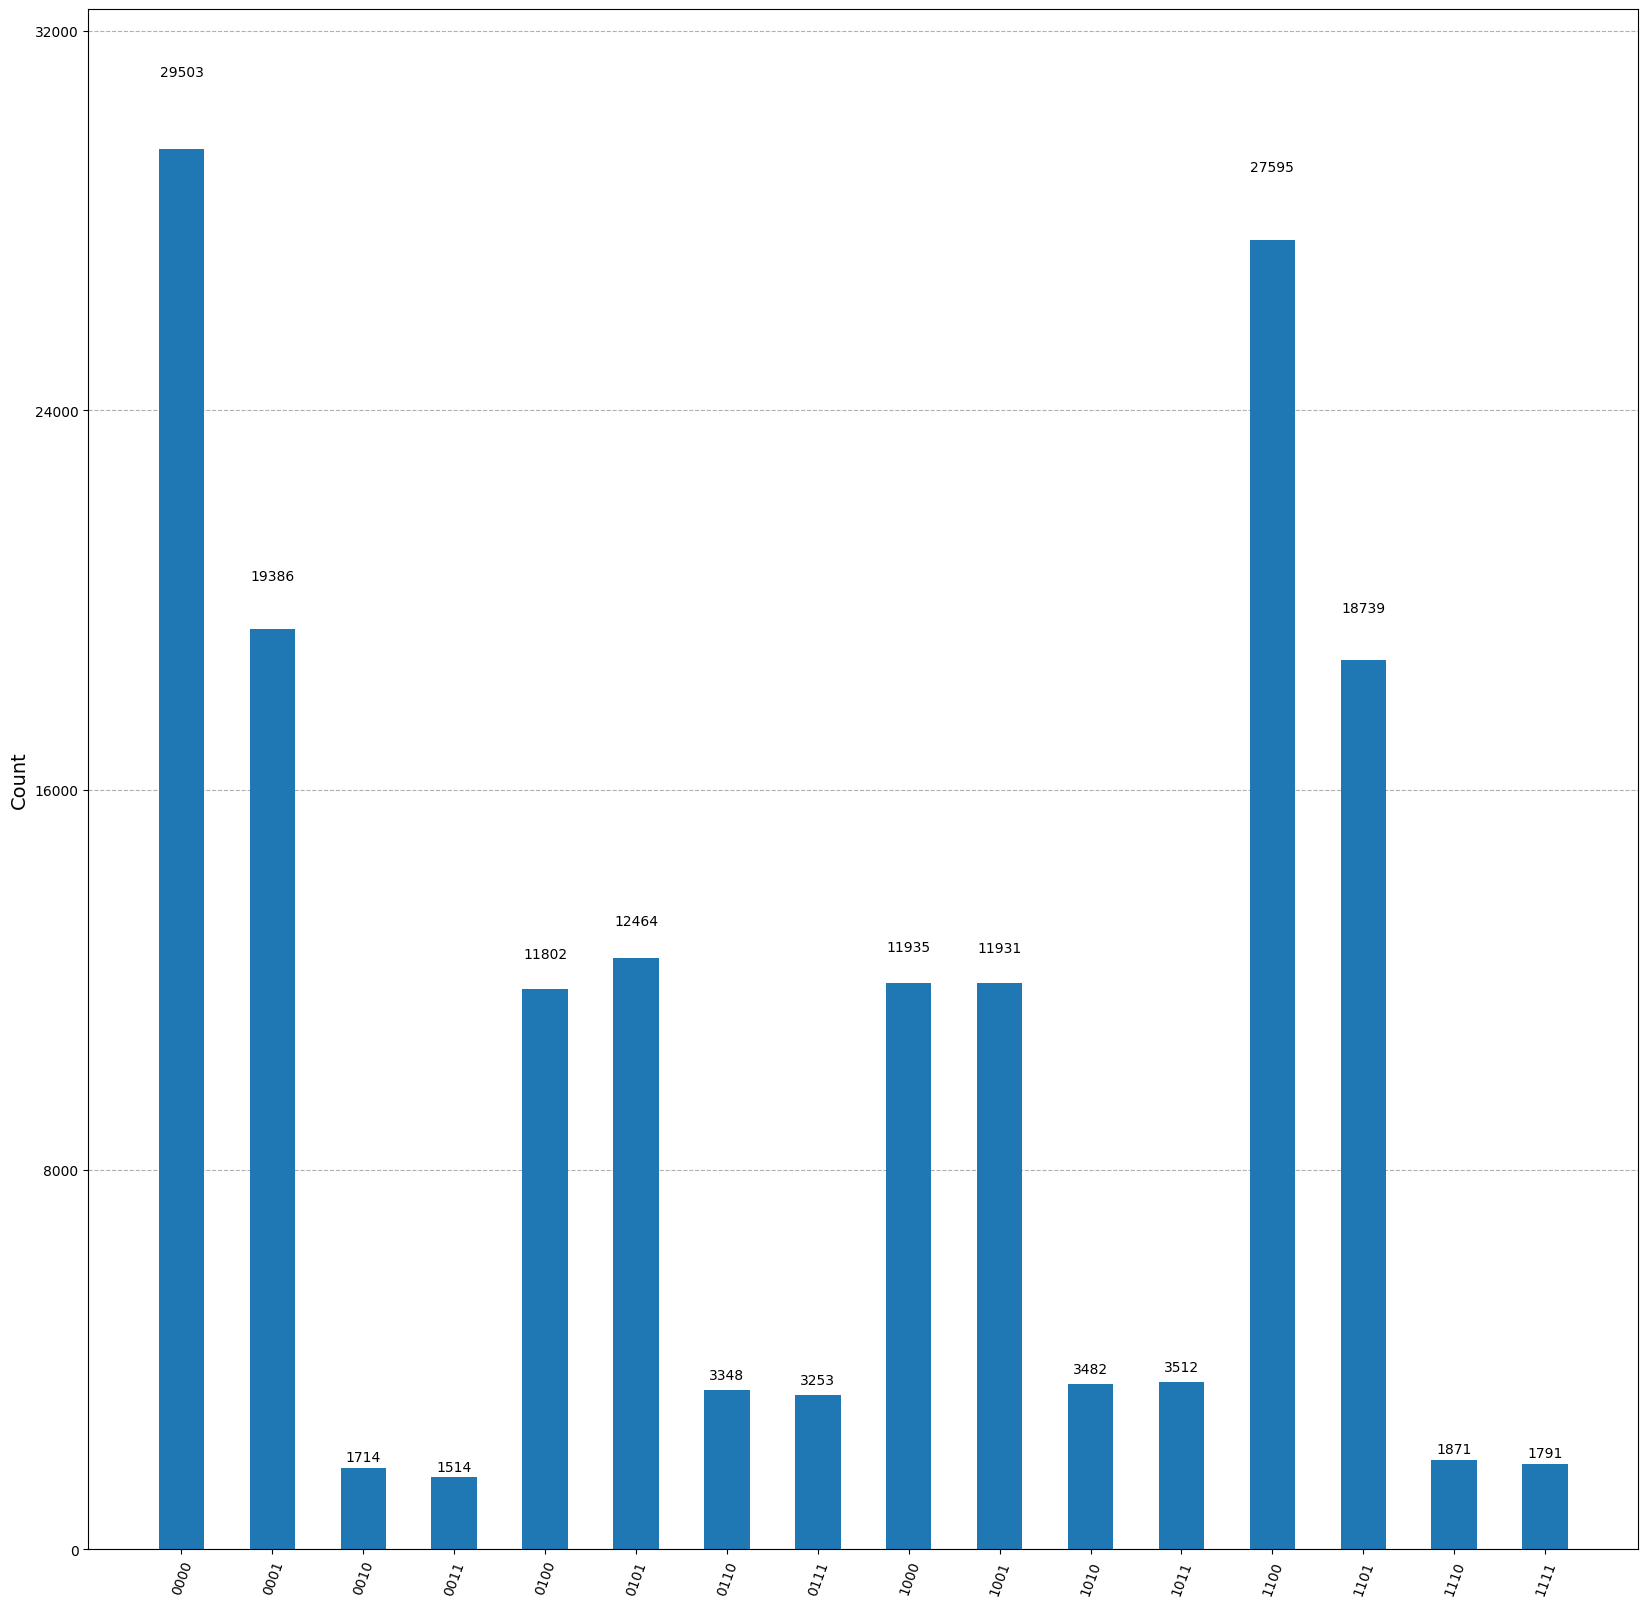

In [22]:
plot_histogram(data=repeat, figsize=(20, 20))

In [21]:
(repeat['0000'] + repeat['1100'])/repeat.total()

0.34849853515625

In [ ]:
from collections import Counter

N=1024

z_0=Counter({})

for iter in range(N):
    # Run calculation
    job = sampler.run([build_isa_circuit(False)],shots=256);
    result = job.result();
    # Get results for the first (and only) PUB
    pub_result = result[0]
    z_0=z_0+Counter(pub_result.data.c5.get_counts())

In [ ]:
(z_0['1100']+z_0['0000']+z_0['0100']+z_0['1000'])/z_0.total()